In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D, MaxPooling2D, Conv2D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout, Activation, Reshape

from sklearn.preprocessing import StandardScaler
from keras import metrics

Using TensorFlow backend.


In [2]:
plt.style.use('ggplot')
plt.rc('patch', force_edgecolor=True,edgecolor='black')
plt.rc('hist', bins='auto')

In [3]:
train = pd.read_csv('all_items_per_shop_train_and_test.csv')

test = pd.read_csv('../csv_folder/test.csv')
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [4]:
train = train.pivot_table(index = ['shop_id','item_id'],
                     values = ['item_cnt_day'],
                     columns = ['date_block_num'],
                     fill_value = 0,
                     aggfunc='sum')

In [5]:
train

item_cnt_day                             ...                 \
date_block_num            0  1  2  3  4  5  6  7  8  9   ... 24 25 26 27 28   
shop_id item_id                                          ...                  
0       0                  0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        1                  0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        2                  0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        3                  0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        4                  0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
...                      ... .. .. .. .. .. .. .. .. ..  ... .. .. .. .. ..   
59      22165              0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        22166              0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        22167              0  0  0  0  0  0  0  0  0  1  ...  0  0  0  0  0   
        22168              0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        22169              0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   

                                
date_block_num  29 30 31 32 33  
shop_id item_id                 
0       0        0  0  0  0  0  
        1        0  0  0  0  0  
        2        0  0  0  0  0  
        3        0  0  0  0  0  
        4        0  0  0  0  0  
...             .. .. .. .. ..  
59      22165    0  0  0  0  0  
        22166    0  0  0  0  0  
        22167    0  0  0  0  0  
        22168    0  0  0  0  0  
        22169    0  0  0  0  0  

[1330200 rows x 34 columns]

In [6]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
train_scaled

array([[-0.11417303, -0.10536222, -0.09455169, ..., -0.05489011,
        -0.01970463, -0.02359814],
       [-0.11417303, -0.10536222, -0.09455169, ..., -0.05489011,
        -0.01970463, -0.02359814],
       [-0.11417303, -0.10536222, -0.09455169, ..., -0.05489011,
        -0.01970463, -0.02359814],
       ...,
       [-0.11417303, -0.10536222, -0.09455169, ..., -0.05489011,
        -0.01970463, -0.02359814],
       [-0.11417303, -0.10536222, -0.09455169, ..., -0.05489011,
        -0.01970463, -0.02359814],
       [-0.11417303, -0.10536222, -0.09455169, ..., -0.05489011,
        -0.01970463, -0.02359814]])

In [7]:
train_scaled.shape

(1330200, 34)

In [8]:
train_scaled.reshape((60, 22170, 34))[:,:,33]

array([[-0.02359814, -0.02359814, -0.02359814, ..., -0.02359814,
        -0.02359814, -0.02359814],
       [-0.02359814, -0.02359814, -0.02359814, ..., -0.02359814,
        -0.02359814, -0.02359814],
       [-0.02359814, -0.02359814, -0.02359814, ..., -0.02359814,
        -0.02359814, -0.02359814],
       ...,
       [-0.02359814, -0.02359814, -0.02359814, ..., -0.02359814,
        -0.02359814, -0.02359814],
       [-0.02359814, -0.02359814, -0.02359814, ..., -0.02359814,
        -0.02359814, -0.02359814],
       [-0.02359814, -0.02359814, -0.02359814, ..., -0.02359814,
        -0.02359814, -0.02359814]])

In [9]:
X_train = train_scaled[:,:-1]
X_test = train_scaled[:,1:]
y_train = train_scaled[:,-1]

print(X_train.shape, y_train.shape, X_test.shape)

(1330200, 33) (1330200,) (1330200, 33)


In [10]:
train_scaled = train_scaled.reshape((60, -1, 34, 1))
print('[samples, subsequences, timesteps, features]')
train_scaled.shape

[samples, subsequences, timesteps, features]


(60, 22170, 34, 1)

In [11]:
X_train = X_train.reshape((60, -1, 33, 1))
X_test = X_test.reshape((60, -1, 33, 1))
y_train = y_train.reshape((60, 22170))

print(X_train.shape, y_train.shape, X_test.shape)

(60, 22170, 33, 1) (60, 22170) (60, 22170, 33, 1)


The model expects a list of seven hyperparameters; they are:

    n_seq: The number of subsequences within a sample.
    n_steps: The number of time steps within each subsequence.
    n_filters: The number of parallel filters.
    n_kernel: The number of time steps considered in each read of the input sequence.
    n_nodes: The number of LSTM units to use in the hidden layer.
    n_epochs: The number of times to expose the model to the whole training dataset.
    n_batch: The number of samples within an epoch after which the weights are updated.  

A simple grid search of model hyperparameters was performed and the configuration below was chosen. This may not be an optimal configuration, but it is the best that was found.  

    n_seq: 3 (i.e. 3 years)
    n_steps: 12 (i.e. 1 year of months)
    n_filters: 64
    n_kernel: 3
    n_nodes: 100
    n_epochs: 200
    n_batch: 100 (i.e. batch gradient descent)



In [12]:
n_steps = 33
n_epochs = 28
n_batch = 60 #21807  #60
n_nodes = 60
n_filters = 1
n_kernel = 1

model = Sequential()
model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel), input_shape=(22170,n_steps, 1)))
model.add(TimeDistributed(Activation("relu")))
model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu')))
model.add(TimeDistributed(MaxPooling1D()))
model.add(TimeDistributed(Flatten()))
# model.add(TimeDistributed(Reshape((-1,))))
# model.add(Dense(1, activation='relu'))
model.add(LSTM(n_nodes, activation='relu'))
model.add(Dense(n_nodes, activation='relu'))
model.add(Dense(22170))
model.compile(loss='mean_absolute_error', optimizer='adam', metrics = ['mean_squared_error'])

# fit
# 'mean_squared_logarithmic_error', binary_crossentropy
# 'Nadam', 'adam', 'RMSprop', 'Ftrl', 'Adamax', 'Adagrad', 'Adadelta', 'SGD'
# 'mean_tensor', 'kullback_leibler_divergence', 'mean_squared_error', 'mean_absolute_error'
# 'logcosh', 'cosine_proximity', 'cosine_similarity'

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 22170, 33, 1)      2         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 22170, 33, 1)      0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 22170, 33, 1)      2         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 22170, 16, 1)      0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 22170, 16)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60)                18480     
_________________________________________________________________
dense_1 (Dense)              (None, 60)               

In [14]:
# fit
n_batch = 22170*33
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=n_batch)

Epoch 1/28
60/60 [==============================] - 80s 1s/step - loss: 0.0461 - mean_squared_error: 1.0000
Epoch 2/28
60/60 [==============================] - 87s 1s/step - loss: 0.0450 - mean_squared_error: 1.0000
Epoch 3/28
60/60 [==============================] - 82s 1s/step - loss: 0.0439 - mean_squared_error: 0.9999
Epoch 4/28
60/60 [==============================] - 84s 1s/step - loss: 0.0426 - mean_squared_error: 0.9999
Epoch 5/28
60/60 [==============================] - 89s 1s/step - loss: 0.0412 - mean_squared_error: 0.9999
Epoch 6/28
60/60 [==============================] - 81s 1s/step - loss: 0.0395 - mean_squared_error: 0.9999
Epoch 7/28
60/60 [==============================] - 80s 1s/step - loss: 0.0377 - mean_squared_error: 0.9998
Epoch 8/28
60/60 [==============================] - 91s 2s/step - loss: 0.0355 - mean_squared_error: 0.9998
Epoch 9/28
60/60 [==============================] - 85s 1s/step - loss: 0.0330 - mean_squared_error: 0.9998
Epoch 10/28
60/60 [=========

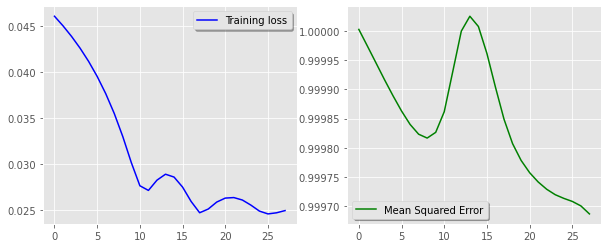

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['mean_squared_error'], color='g', label='Mean Squared Error')
ax[1].legend(loc='best', shadow=True)

In [16]:
# creating submission file 
submission_pfs = model.predict(X_test)

In [17]:
submission_pfs.shape

(60, 22170)

In [18]:
predictions = pd.DataFrame(submission_pfs.flatten(), index=train.index, columns=['item_cnt_month']).reset_index()

In [19]:
predictions

,shop_id,item_id,item_cnt_month
0,0,0,-0.024404
1,0,1,-0.024499
2,0,2,-0.024493
3,0,3,-0.024927
4,0,4,-0.024901
...,...,...,...
1330195,59,22165,-0.025162
1330196,59,22166,-0.024954
1330197,59,22167,-0.023141
1330198,59,22168,-0.024687


In [20]:
train

item_cnt_day                             ...                 \
date_block_num            0  1  2  3  4  5  6  7  8  9   ... 24 25 26 27 28   
shop_id item_id                                          ...                  
0       0                  0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        1                  0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        2                  0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        3                  0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        4                  0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
...                      ... .. .. .. .. .. .. .. .. ..  ... .. .. .. .. ..   
59      22165              0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        22166              0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        22167              0  0  0  0  0  0  0  0  0  1  ...  0  0  0  0  0   
        22168              0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        22169              0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   

                                
date_block_num  29 30 31 32 33  
shop_id item_id                 
0       0        0  0  0  0  0  
        1        0  0  0  0  0  
        2        0  0  0  0  0  
        3        0  0  0  0  0  
        4        0  0  0  0  0  
...             .. .. .. .. ..  
59      22165    0  0  0  0  0  
        22166    0  0  0  0  0  
        22167    0  0  0  0  0  
        22168    0  0  0  0  0  
        22169    0  0  0  0  0  

[1330200 rows x 34 columns]

In [21]:
train_scaled.shape

(60, 22170, 34, 1)

In [22]:
train_scaled = train_scaled.reshape(1330200, 34)

In [23]:
train_scaled.shape

(1330200, 34)

In [24]:
scaled_df = pd.DataFrame(train_scaled)
scaled_df

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,-0.114173,-0.105362,-0.094552,-0.103719,-0.070461,-0.050156,-0.056699,-0.057016,-0.044758,-0.049564,...,-0.039201,-0.072942,-0.072746,-0.028918,-0.03384,-0.050094,-0.053175,-0.05489,-0.019705,-0.023598
1,-0.114173,-0.105362,-0.094552,-0.103719,-0.070461,-0.050156,-0.056699,-0.057016,-0.044758,-0.049564,...,-0.039201,-0.072942,-0.072746,-0.028918,-0.03384,-0.050094,-0.053175,-0.05489,-0.019705,-0.023598
2,-0.114173,-0.105362,-0.094552,-0.103719,-0.070461,-0.050156,-0.056699,-0.057016,-0.044758,-0.049564,...,-0.039201,-0.072942,-0.072746,-0.028918,-0.03384,-0.050094,-0.053175,-0.05489,-0.019705,-0.023598
3,-0.114173,-0.105362,-0.094552,-0.103719,-0.070461,-0.050156,-0.056699,-0.057016,-0.044758,-0.049564,...,-0.039201,-0.072942,-0.072746,-0.028918,-0.03384,-0.050094,-0.053175,-0.05489,-0.019705,-0.023598
4,-0.114173,-0.105362,-0.094552,-0.103719,-0.070461,-0.050156,-0.056699,-0.057016,-0.044758,-0.049564,...,-0.039201,-0.072942,-0.072746,-0.028918,-0.03384,-0.050094,-0.053175,-0.05489,-0.019705,-0.023598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1330195,-0.114173,-0.105362,-0.094552,-0.103719,-0.070461,-0.050156,-0.056699,-0.057016,-0.044758,-0.049564,...,-0.039201,-0.072942,-0.072746,-0.028918,-0.03384,-0.050094,-0.053175,-0.05489,-0.019705,-0.023598
1330196,-0.114173,-0.105362,-0.094552,-0.103719,-0.070461,-0.050156,-0.056699,-0.057016,-0.044758,-0.049564,...,-0.039201,-0.072942,-0.072746,-0.028918,-0.03384,-0.050094,-0.053175,-0.05489,-0.019705,-0.023598
1330197,-0.114173,-0.105362,-0.094552,-0.103719,-0.070461,-0.050156,-0.056699,-0.057016,-0.044758,0.467370,...,-0.039201,-0.072942,-0.072746,-0.028918,-0.03384,-0.050094,-0.053175,-0.05489,-0.019705,-0.023598
1330198,-0.114173,-0.105362,-0.094552,-0.103719,-0.070461,-0.050156,-0.056699,-0.057016,-0.044758,-0.049564,...,-0.039201,-0.072942,-0.072746,-0.028918,-0.03384,-0.050094,-0.053175,-0.05489,-0.019705,-0.023598


In [25]:
scaled_df[34] = predictions['item_cnt_month']

In [26]:
scaled_df = scaled_df.drop(columns=[0])

In [27]:
submit_unscaled = scaler.inverse_transform(scaled_df)

In [28]:
submit_df = pd.DataFrame(submit_unscaled, columns=list(range(1, 35)))

In [29]:
submit_df[34]

0         -0.001825
1         -0.002039
2         -0.002026
3         -0.003009
4         -0.002950
             ...   
1330195   -0.003539
1330196   -0.003069
1330197    0.001035
1330198   -0.002465
1330199   -0.002511
Name: 34, Length: 1330200, dtype: float64

In [30]:
predictions['item_cnt_month'] = submit_df[34]

In [31]:
submit = pd.merge(test, predictions, how='inner', left_on=['shop_id', 'item_id'], right_on=['shop_id', 'item_id'])

In [32]:
submit

,ID,shop_id,item_id,item_cnt_month
0,0,5,5037,0.003529
1,1,5,5320,-0.002127
2,2,5,5233,0.006458
3,3,5,5232,0.004079
4,4,5,5268,-0.003687
...,...,...,...,...
214195,214195,45,18454,-0.003746
214196,214196,45,16188,-0.002608
214197,214197,45,15757,0.000779
214198,214198,45,19648,-0.001881


In [33]:
submit.drop(columns=['shop_id', 'item_id'], inplace=True)

In [34]:
# we will keep every value between 0 and 20
submit['item_cnt_month'] = submit['item_cnt_month'].clip(0,20)

In [35]:
submit.to_csv('../submission_files/1dconv_28epoch_stdscaler_maeloss_alldata.csv',index = False)

In [36]:
submit

,ID,item_cnt_month
0,0,0.003529
1,1,0.000000
2,2,0.006458
3,3,0.004079
4,4,0.000000
...,...,...
214195,214195,0.000000
214196,214196,0.000000
214197,214197,0.000779
214198,214198,0.000000
